In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
num_GPU = len(os.environ["CUDA_VISIBLE_DEVICES"].split(',')) 

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)


In [2]:
print(os.environ["CUDA_VISIBLE_DEVICES"])
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if len(gpus):
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Restricting Memory")
    except RuntimeError as e:
        print(e)

5
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Restricting Memory


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm import tqdm_notebook as tqdm
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

import keras_helper
from keras_helper import *
from skimage.transform import resize


### Read test data

In [4]:
h=64
w=64

ScanNo = 902

path = '/home/beams3/YUDONGYAO/projects/Deep_Learning_project/PtychoNN_bd/'

#load test diff
data_diffr_test = np.load(path+'data/2020-3-7IDB_diff_S%05d_64.npz' %ScanNo)['arr_0']
#load test amp and phi   
amp = np.load(path+'data/2020-3-7IDB_data_S%05d.npz' %ScanNo)['arr_0']
ph = np.load(path+'data/2020-3-7IDB_data_S%05d.npz' %ScanNo)['arr_1']

# reshape
X_test = data_diffr_test.reshape(-1,data_diffr_test.shape[1],data_diffr_test.shape[2])[:,:,:,np.newaxis]
Y_I_test = amp.reshape(-1,h,w)[:,:,:,np.newaxis]
Y_phi_test = ph.reshape(-1,h,w)[:,:,:,np.newaxis]


print(X_test.shape)


(1209, 64, 64, 1)


### Load the model from the epoch with lowest validation error

In [5]:
result_name='wts_bd_7idb-TP' 
wt_path = path + 'Results/'+ result_name 
min_epoch = np.load('%s/min_epoch.npy' %wt_path)
from keras.models import Model, load_model
model=load_model('%s/weights.%02d.hdf5' %(wt_path,min_epoch))
print ("Loaded model from epoch:%d" %min_epoch)

Loaded model from epoch:89


### Make prediction using the diffraction data alone

In [6]:
preds_intens=(model.predict(X_test))
preds_amp = preds_intens[0]
preds_phi = preds_intens[1]

# Plot some instances of the test data, it's FT and the CNN prediction

<Figure size 432x288 with 0 Axes>

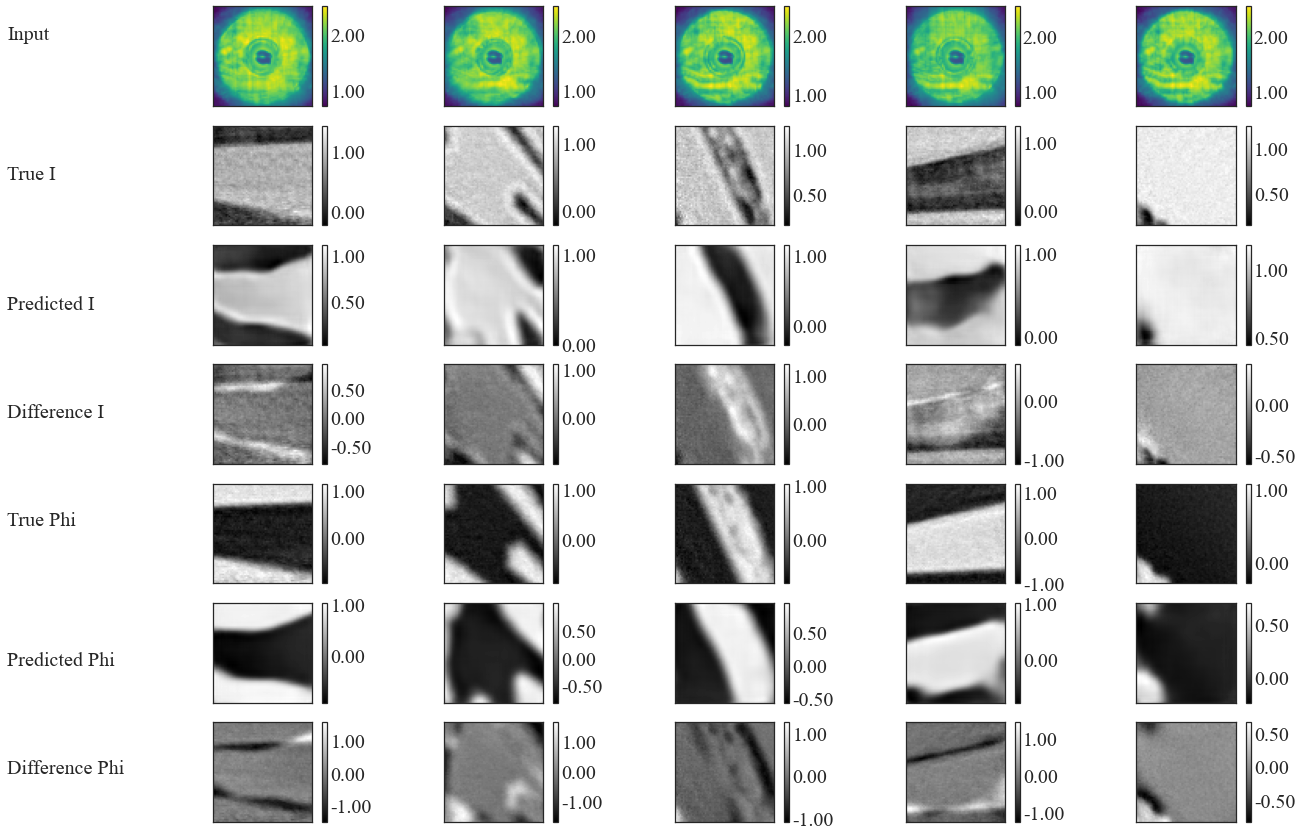

In [8]:
ntest=preds_intens[0].shape[0]
plt.viridis()
n = 5
f,ax=plt.subplots(7,n,figsize=(20, 15))
plt.gcf().text(0.02, 0.85, "Input", fontsize=20)
plt.gcf().text(0.02, 0.72, "True I", fontsize=20)
plt.gcf().text(0.02, 0.6, "Predicted I", fontsize=20)
plt.gcf().text(0.02, 0.5, "Difference I", fontsize=20)
plt.gcf().text(0.02, 0.4, "True Phi", fontsize=20)
plt.gcf().text(0.02, 0.27, "Predicted Phi", fontsize=20)
plt.gcf().text(0.02, 0.17, "Difference Phi", fontsize=20)

for i in range(0,n):
    j=int(round(np.random.rand()*ntest))

    # display FT
    im=ax[0,i].imshow(np.log10(X_test[j,:,:].reshape(X_test.shape[1], X_test.shape[2])+1))
    plt.colorbar(im, ax=ax[0,i], format='%.2f')
    ax[0,i].get_xaxis().set_visible(False)
    ax[0,i].get_yaxis().set_visible(False)

    # display original intens
    im=ax[1,i].imshow(Y_I_test[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[1,i], format='%.2f')
    ax[1,i].get_xaxis().set_visible(False)
    ax[1,i].get_yaxis().set_visible(False)
    
    # display predicted intens
    im=ax[2,i].imshow(preds_amp[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[2,i], format='%.2f')
    ax[2,i].get_xaxis().set_visible(False)
    ax[2,i].get_yaxis().set_visible(False)
    
    # display original phase
    im=ax[4,i].imshow(Y_phi_test[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[4,i], format='%.2f')
    ax[4,i].get_xaxis().set_visible(False)
    ax[4,i].get_yaxis().set_visible(False)
    
    # display predicted phase
    im=ax[5,i].imshow(preds_phi[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[5,i], format='%.2f')
    ax[5,i].get_xaxis().set_visible(False)
    ax[5,i].get_yaxis().set_visible(False)
    
    #Difference in amplitude
    im=ax[3,i].imshow(Y_I_test[j].reshape(h, w)-preds_amp[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[3,i], format='%.2f')
    ax[3,i].get_xaxis().set_visible(False)
    ax[3,i].get_yaxis().set_visible(False)
    
    # Difference in phase
    im=ax[6,i].imshow(Y_phi_test[j].reshape(h, w)-preds_phi[j].reshape(h, w), cmap = 'gray')
    plt.colorbar(im, ax=ax[6,i], format='%.2f')
    ax[6,i].get_xaxis().set_visible(False)
    ax[6,i].get_yaxis().set_visible(False)
    
plt.show()

# Stitch predictions together

(1209,)


(<AxesSubplot:>,
 <matplotlib.colorbar.Colorbar at 0x7fb7440f2050>)

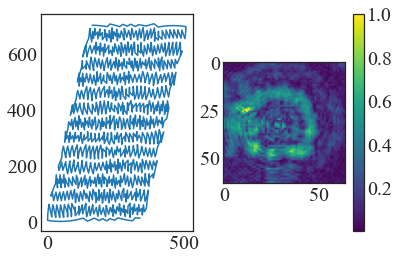

In [9]:
# load position
pos = np.load('data/2020-3-7IDB_data_S%05d.npz' %ScanNo)['arr_2']

pos_row = (pos[1]-np.min(pos[1]))
pos_col = (pos[0]-np.min(pos[0]))

print(pos_row.shape)

# integer position
pos_int_row = pos_row.astype(np.int32)
pos_int_col = pos_col.astype(np.int32)

pos_subpixel_row = pos_row - pos_int_row
pos_subpixel_col = pos_col - pos_int_col

pb_weight = np.load('data/2020-3-7IDB_probe_TP_weight.npz')['arr_0']

plt.subplot(1,2,1),plt.plot(pos_col,pos_row)
plt.subplot(1,2,2),plt.imshow(pb_weight),plt.colorbar()


In [161]:

composite_amp = np.zeros((np.max(pos_int_row)+64,np.max(pos_int_col)+64),float)

print(composite_amp.shape)
ctr = np.zeros_like(composite_amp)

data_reshaped = preds_amp.reshape(preds_amp.shape[0],64,64)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
#     weight_tmp = np.real(sub_shift.subpixel_shift(pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_amp[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64] += data_reshaped[i]*pb_weight
    ctr[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64] += pb_weight
    
composite_amp = composite_amp[32:-32,32:-32]
ctr = ctr[32:-32,32:-32]
   
print(composite_amp.shape)

(769, 572)
(1209, 64, 64)
(705, 508)


In [162]:
composite_phase = np.zeros((np.max(pos_int_row)+64,np.max(pos_int_col)+64),float)
print(composite_phase.shape)

data_reshaped = preds_phi.reshape(preds_phi.shape[0],64,64)
print(data_reshaped.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_phase[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64]  += data_reshaped[i]*pb_weight

composite_phase = composite_phase[32:-32,32:-32]

print(composite_phase.shape)


(769, 572)
(1209, 64, 64)
(705, 508)


In [163]:
stitched_phase = np.zeros_like(composite_phase)
print(stitched_phase.shape)

stitched_phase[np.where(ctr!=0)] = composite_phase[np.where(ctr!=0)]/ctr[np.where(ctr!=0)]
print(stitched_phase.shape)

stitched_amp = np.ones_like(composite_amp)
stitched_amp[np.where(ctr!=0)] = composite_amp[np.where(ctr!=0)]/ctr[np.where(ctr!=0)]


(705, 508)
(705, 508)


## Plot the ePIE reconstruction, the PtychoNN prediction and the difference between the two

In [164]:
composite_amp_true = np.zeros((np.max(pos_int_row)+64,np.max(pos_int_col)+64),float)
print(composite_amp_true.shape)
ctr_true = np.zeros_like(composite_amp_true)

data_reshaped_true = Y_I_test.reshape(preds_intens[0].shape[0],64,64)
print(data_reshaped_true.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped_true[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
#     weight_tmp = np.real(sub_shift.subpixel_shift(pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_amp_true[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64] += data_reshaped_true[i]*pb_weight
    ctr_true[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64] += pb_weight

composite_amp_true = composite_amp_true[32:-32,32:-32]
ctr_true = ctr_true[32:-32,32:-32]

print(composite_amp_true.shape)


(769, 572)
(1209, 64, 64)
(705, 508)


In [165]:
composite_phase_true = np.zeros((np.max(pos_int_row)+64,np.max(pos_int_col)+64),float)
print(composite_phase_true.shape)

data_reshaped_true = Y_phi_test.reshape(preds_phi.shape[0],64,64)
print(data_reshaped_true.shape)

for i in range(pos_row.shape[0]):
#     data_tmp = np.real(sub_shift.subpixel_shift(data_reshaped_true[i]*pb_weight,pos_subpixel_row[i],pos_subpixel_col[i]))
    composite_phase_true[pos_int_row[i]:pos_int_row[i]+64,pos_int_col[i]:pos_int_col[i]+64] += data_reshaped_true[i]*pb_weight

composite_phase_true = composite_phase_true[32:-32,32:-32]
    
print(composite_phase_true.shape)

(769, 572)
(1209, 64, 64)
(705, 508)


In [166]:
stitched_phase_true = np.zeros_like(composite_phase_true)
print(stitched_phase_true.shape)

stitched_phase_true[np.where(ctr_true!=0)] = composite_phase_true[np.where(ctr_true!=0)]/ctr[np.where(ctr_true!=0)]
print(stitched_phase_true.shape)

stitched_amp_true = np.ones_like(composite_amp_true)
stitched_amp_true[np.where(ctr_true!=0)] = composite_amp_true[np.where(ctr_true!=0)]/ctr[np.where(ctr_true!=0)]


(705, 508)
(705, 508)


(-0.5, 507.5, 704.5, -0.5)

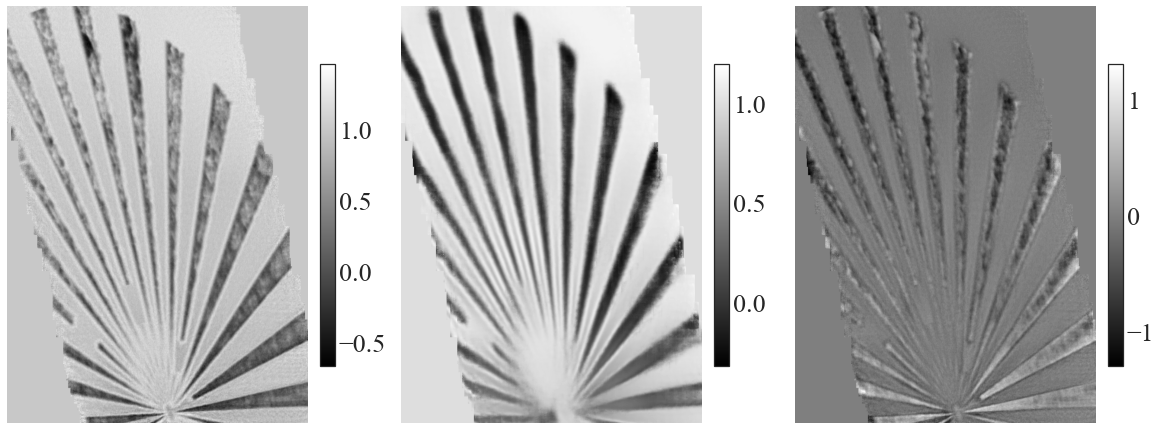

In [167]:

plt.rcParams.update({'font.size': 26})
fig, ax = plt.subplots(1,3,figsize=(20,12))

im=ax[0].imshow(stitched_amp_true, cmap = 'gray')
ax[0].axis('off')
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)

im=ax[1].imshow(stitched_amp,cmap = 'gray')
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_amp-stitched_amp_true,cmap = 'gray')
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

(-0.5, 507.5, 704.5, -0.5)

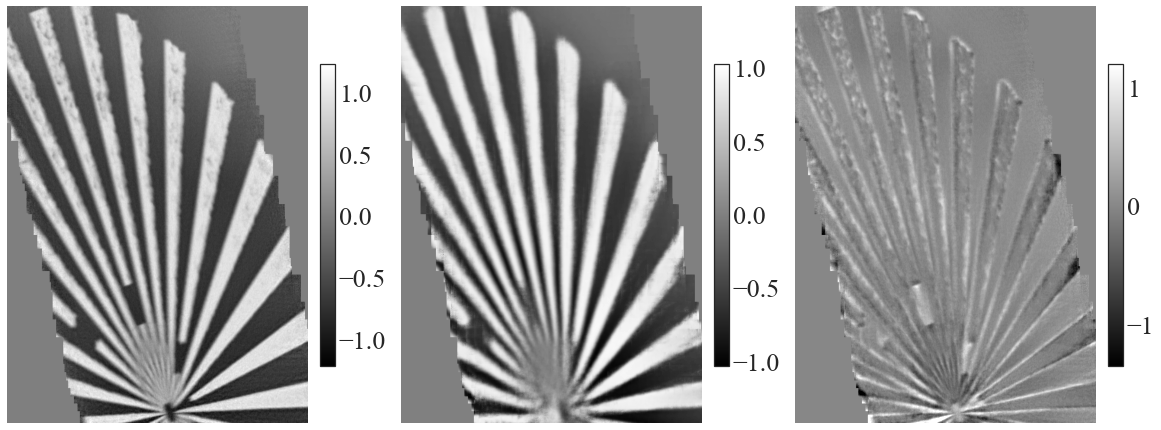

In [168]:

fig, ax = plt.subplots(1,3,figsize=(20,10))

im=ax[0].imshow(stitched_phase_true, cmap = 'gray')#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[0], fraction=0.046, pad=0.04)
ax[0].axis('off')

im=ax[1].imshow(stitched_phase, cmap = 'gray')#,vmin=minc, vmax=maxc)
plt.colorbar(im,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].axis('off')

im=ax[2].imshow(stitched_phase-stitched_phase_true, cmap = 'gray',vmin=-1.35, vmax=1.2)
plt.colorbar(im,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].axis('off')

In [149]:
(stitched_phase-stitched_phase_true).max()

0.323619835586729

### Quantify MSE error between phase retrieval and PtychoNN

In [150]:
from sklearn.metrics import mean_squared_error as mse
print ("MSE in amplitude: ", mse(stitched_amp, stitched_amp_true))
print ("MSE in phase: ", mse(stitched_phase, stitched_phase_true))

MSE in amplitude:  0.000727439672936103
MSE in phase:  0.004422335952786671
